In [31]:
import pandas as pd
import json
import spacy
import re
from collections import defaultdict

# Load the English NLP model from spaCy
nlp = spacy.load("en_core_web_sm")

def load_raw_data(json_file):
    """Load raw text data from JSON file."""
    with open(json_file, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    return raw_data

def categorize_time(time_str):
    """Categorize specific time mentions into morning, afternoon, night, or not specified."""
    time_str = time_str.lower().strip()
    
    # Direct matches
    if time_str == "not specified":
        return "not specified"
    if "morning" in time_str or "am" in time_str or "breakfast" in time_str:
        return "morning"
    if "afternoon" in time_str or "noon" in time_str or "lunch" in time_str:
        return "afternoon"
    if "night" in time_str or "evening" in time_str or "pm" in time_str or "dinner" in time_str or "bedtime" in time_str:
        return "night"
    
    # Specific time parsing
    time_match = re.search(r"(\d{1,2})(?::\d{2})?\s*(am|pm)", time_str)
    if time_match:
        hour, period = int(time_match.group(1)), time_match.group(2)
        if period == "am":
            return "morning" if hour < 12 else "night"  # e.g., 1 AM is night
        if period == "pm":
            return "afternoon" if hour < 6 else "night"  # e.g., 2 PM is afternoon, 7 PM is night
    
    # Default to not specified if unclear
    return "not specified"

def is_negative_context(sentence, time_idx, window=10):
    """Check if a negative keyword appears within a window of words after the time mention."""
    negative_keywords = ["danger", "avoid", "problem", "issue", "harm", "negative", "bad"]
    words = sentence.split()
    context_window = " ".join(words[time_idx:time_idx + window] if time_idx + window < len(words) else words[time_idx:]).lower()
    
    # Check for "risk" but exclude positive phrases like "risk reduce" or "risk lower"
    if "risk" in context_window:
        if any(phrase in context_window for phrase in ["risk reduce", "risk lower", "risk reduction"]):
            return False  # Not negative if risk is reduced/lowered
        return True  # Negative if "risk" appears without positive modifiers
    
    return any(kw in context_window for kw in negative_keywords)

def extract_benefits_risks(doc, drink):
    """Extract benefits and risks as short phrases related to the drink, handling 'risk' carefully."""
    benefits = []
    risks = []
    
    benefit_keywords = ["benefit", "helps", "boosts", "improves", "good", "enhances", "promotes", "reduce", "lower"]
    risk_keywords = ["danger", "harm", "causes", "bad", "disrupts", "impairs"]
    
    for sent in doc.sents:
        sent_text = sent.text.lower()
        if drink not in sent_text:
            continue
        
        # Look for benefits (including positive risk phrases)
        if any(kw in sent_text for kw in benefit_keywords) or "risk reduce" in sent_text or "risk lower" in sent_text:
            for token in sent:
                if token.text in benefit_keywords and token.head:
                    phrase = f"{token.text} {token.head.text}"
                    benefits.append(phrase)
                elif token.text == "risk" and token.head.text in ["reduce", "lower", "reduction"]:
                    phrase = f"{token.text} {token.head.text}"
                    benefits.append(phrase)  # Treat "risk reduce" as a benefit
        
        # Look for risks (excluding positive risk phrases)
        if any(kw in sent_text for kw in risk_keywords) or ("risk" in sent_text and not any(p in sent_text for p in ["reduce", "lower", "reduction"])):
            for token in sent:
                if token.text in risk_keywords and token.head:
                    phrase = f"{token.text} {token.head.text}"
                    risks.append(phrase)
                elif token.text == "risk" and token.head.text not in ["reduce", "lower", "reduction"] and token.head:
                    phrase = f"{token.text} {token.head.text}"
                    risks.append(phrase)  # Only add "risk" if not followed by positive modifiers
    
    return benefits[:5], risks[:5]  # Limit to top 5 for brevity

def process_raw_text(raw_data):
    """Process raw text to extract time, drink, source, benefits, and risks."""
    coffee_types = {"coffee", "espresso", "cappuccino", "latte", "americano", "mocha", "macchiato", "café", "java", "brew", "decaf"}
    tea_types = {"tea", "green tea", "black tea", "herbal tea", "chamomile", "oolong", "white tea", "matcha", "chai", "earl grey", "pu-erh"}
    
    findings = []
    
    for entry in raw_data:
        text = entry["text"]
        source = entry["source"]
        doc = nlp(text)
        
        for sent in doc.sents:
            sent_text = sent.text.lower()
            
            # Detect drink
            coffee_match = any(drink in sent_text for drink in coffee_types)
            tea_match = any(drink in sent_text for drink in tea_types)
            if not (coffee_match or tea_match):
                continue
            
            drink = "coffee" if coffee_match else "tea"
            
            # Extract time
            time_patterns = [
                r"(\d{1,2}(?::\d{2})?\s*(?:am|pm))",
                r"(\d{1,2}\s*o'clock)",
                r"(early|mid|late)\s+(morning|afternoon|evening)",
                r"(before|after|during)\s+(breakfast|lunch|dinner|meal)",
                r"(before|after)\s+(workout|exercise|gym|run)",
                r"(before|at|after)\s+(sunrise|sunset|dawn|dusk)",
                r"(morning|afternoon|evening|night|noon|midnight)"
            ]
            
            time_info = "Not specified"
            time_idx = -1
            for pattern in time_patterns:
                match = re.search(pattern, sent_text, re.IGNORECASE)
                if match:
                    time_info = match.group(0)
                    time_idx = len(sent_text[:match.start()].split())
                    break
            
            # Categorize time
            categorized_time = categorize_time(time_info)
            
            # Check for negative context
            if time_idx != -1 and is_negative_context(sent_text, time_idx):
                continue  # Skip if negative context is detected
            
            # Extract benefits and risks
            benefits, risks = extract_benefits_risks(sent, drink)
            
            # Add finding
            findings.append({
                "drink": drink,
                "time": categorized_time,
                "source": source,
                "benefits": benefits,
                "risks": risks
            })
    
    print(f"Extracted {len(findings)} refined findings")
    return findings

def main():
    # File paths
    json_file = "coffee_tea_times/coffee_tea_raw_20250309_082055.json"
    output_dir = "coffee_tea_times"
    
    # Load raw data
    raw_data = load_raw_data(json_file)
    
    # Process data
    findings = process_raw_text(raw_data)
    
    # Save results
    if findings:
        df = pd.DataFrame(findings)
        timestamp = "20250309_082055"  # Reuse original timestamp for consistency
        excel_file = f"{output_dir}/coffee_tea_refined_{timestamp}.xlsx"
        df.to_excel(excel_file, index=False, engine="openpyxl")
        print(f"Refined data saved to {excel_file}")
        
        json_file_out = f"{output_dir}/coffee_tea_refined_{timestamp}.json"
        with open(json_file_out, 'w', encoding='utf-8') as f:
            json.dump(findings, f, ensure_ascii=False, indent=2)
        print(f"Refined JSON saved to {json_file_out}")

if __name__ == "__main__":
    # Ensure spaCy model is installed: run `python -m spacy download en_core_web_sm` if not already done
    main()

Extracted 1922 refined findings
Refined data saved to coffee_tea_times/coffee_tea_refined_20250309_082055.xlsx
Refined JSON saved to coffee_tea_times/coffee_tea_refined_20250309_082055.json


In [32]:
# Checking if data was correctly categorized
data = pd.read_excel('coffee_tea_times/coffee_tea_refined_20250309_082055.xlsx')
print(data['time'].unique(), '...' ,data.columns)

['not specified' 'morning' 'afternoon' 'night'] ... Index(['drink', 'time', 'source', 'benefits', 'risks'], dtype='object')


C:\Users\Portables\AppData\Local\Temp\ipykernel_14544\3052917103.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


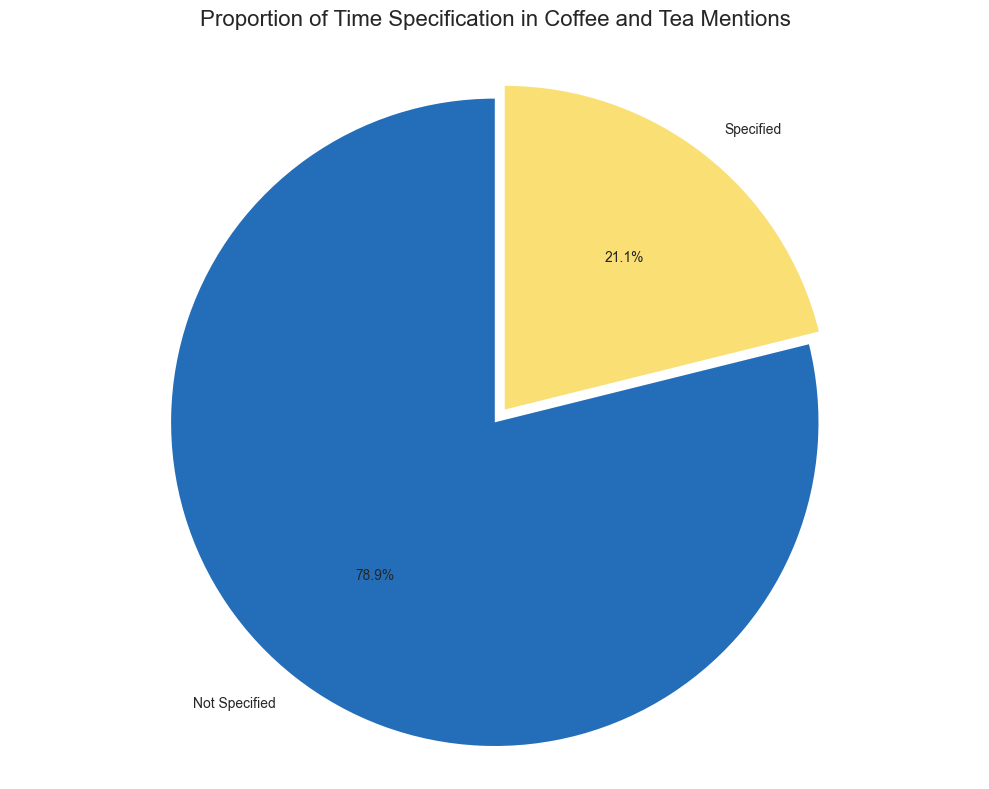

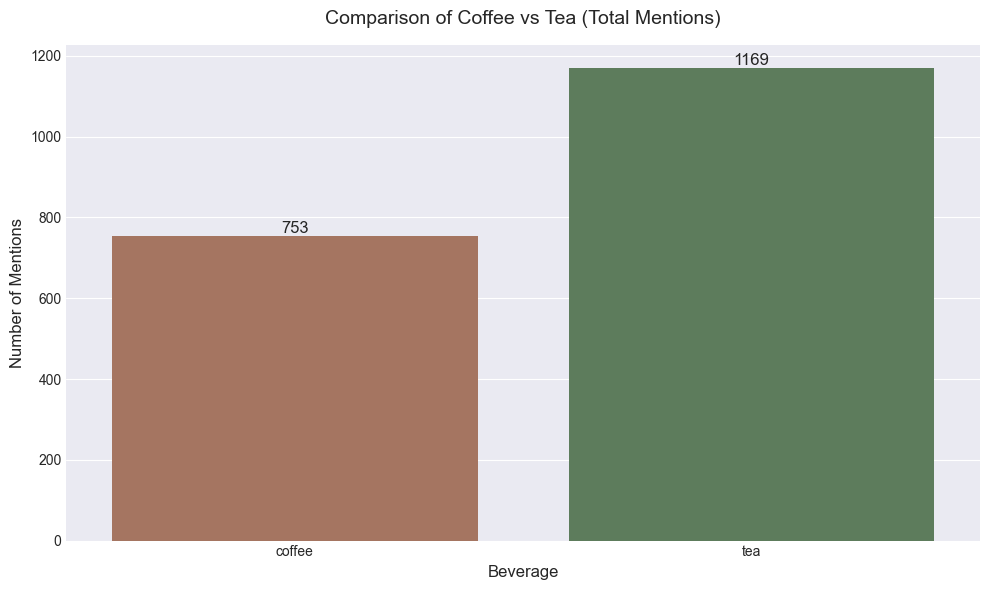

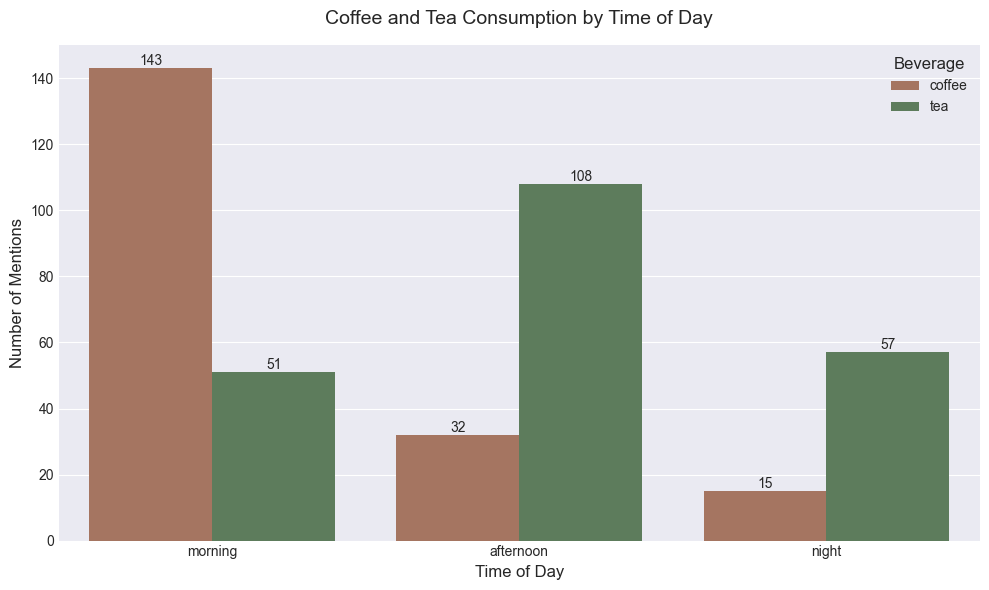

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load refined data
data = pd.read_excel('coffee_tea_times/coffee_tea_refined_20250309_082055.xlsx')

# Set plot style
plt.style.use('seaborn-darkgrid')
sns.set_palette("muted")

sp_colors = {'specified': '#246EB9', 'not_specified': '#F9DF74'}

# Pie Chart: Specified vs Not Specified
plt.figure(figsize=(10, 8))
time_specification = data['time'].apply(lambda x: 'Specified' if x != 'not specified' else 'Not Specified')
specification_counts = time_specification.value_counts()

plt.pie(specification_counts.values, labels=specification_counts.index, autopct='%1.1f%%',
        startangle=90, explode=(0.05, 0), colors=[sp_colors['specified'], sp_colors['not_specified']])
plt.title('Proportion of Time Specification in Coffee and Tea Mentions', fontsize=16, pad=20)
plt.axis('equal')
plt.tight_layout()
plt.savefig('coffee_tea_times/time_specification_pie.png', dpi=300)
plt.show()

# Bar Chart: Coffee vs Tea Comparison
beverage_colors = {'coffee': '#B07156', 'tea': '#588157'}
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=data, x='drink', hue='drink', order=['coffee', 'tea'], palette=beverage_colors, legend=False)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)

plt.title('Comparison of Coffee vs Tea (Total Mentions)', fontsize=14, pad=15)
plt.xlabel('Beverage', fontsize=12)
plt.ylabel('Number of Mentions', fontsize=12)
plt.tight_layout()
plt.savefig('coffee_tea_times/total_comparison.png', dpi=300)
plt.show()

# Bar Chart: Coffee and Tea Consumption by Time of Day
filtered_data = data[data['time'] != 'not specified']
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=filtered_data, x='time', hue='drink', order=['morning', 'afternoon', 'night'], palette=beverage_colors)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=10)

plt.title('Coffee and Tea Consumption by Time of Day', fontsize=14, pad=15)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Number of Mentions', fontsize=12)
plt.legend(title='Beverage', title_fontsize=12, fontsize=10)
plt.tight_layout()
plt.savefig('coffee_tea_times/time_comparison.png', dpi=300)
plt.show()


In [46]:
len(list(data['source'].unique()))

64